#  <center> Walmart Product Review Analysis </center>

### Goal
Cuurrently, Walmart's online market promotes clothing products by price range and brand. I do not believe they have a way to analyze customer's reviews and promote items based on customer's "Recommended" score.    

This analysis will look at Walmart clothing reviews to find key features that predict whether a customer will recommend an item or not. This investigation will be conducted using [Natural Language Processing](https://en.wikipedia.org/wiki/Natural_language_processing) packages and libraries. The features that guide the predictions can then used to guide Walmart's online and/or in-store marketing/product campaigns. 

In [166]:
# Data Cleaning and analysis packages
import pandas as pd
import numpy as np


# NLP packages
import gensim
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer

# Sats and Modeling packages
from sklearn import metrics
from scipy import stats
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression


# Visualization packages
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="dark")
sns.set(style="whitegrid", color_codes=True)

import pickle
import warnings
warnings.filterwarnings("ignore") 


pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 200)

In [74]:
filename = "data/modeling_df.pkl"

In [75]:
infile = open(filename,"rb")
df = pickle.load(infile)
infile.close()

In [76]:
df.head(2)

,item_name,price,overall_rating,num_rating,recommend,rev_title,review_text,section,target,rating_bin,clean_rev_title,clean_review_text,tokenized,rem_stop,lemma_words,delisted,girls',men's,women's,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
0,Wrangler Men's Unlined Shirt Jacket,12.0,4.0,7.0,80.0,['Texas winter ready!'],['I bought this last year and am going to buy ...,men's clothing,0,1,texas winter ready,i bought this last year and am going to buy an...,"[i, bought, this, last, year, and, am, going, ...","[bought, last, year, going, buy, another, frid...","[bought, last, year, going, buy, another, frid...","bought, last, year, going, buy, another, frida...",0.0,1.0,0.0,0.011114,0.011114,0.011114,0.899972,0.011114,0.011114,0.011114,0.011114,0.011114,0.011114
1,Wrangler Men's Relaxed Fit Jeans,12.0,4.5,5840.0,90.0,"['Wrangler is the best.', 'My Favorite Jeans',...","['I like wrangler, the pants is exactly for my...",men's clothing,1,1,wrangler is the best my favorite jeans extreme...,i like wrangler the pants is exactly for my bo...,"[i, like, wrangler, the, pants, is, exactly, f...","[like, wrangler, pants, exactly, body, also, g...","[like, wrangler, pant, exactly, body, also, go...","like, wrangler, pant, exactly, body, also, goo...",0.0,1.0,0.0,0.000000,0.000000,0.000000,0.998047,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [77]:
df.isna().sum()

item_name            0
price                0
overall_rating       0
num_rating           0
recommend            0
rev_title            0
review_text          0
section              0
target               0
rating_bin           0
clean_rev_title      0
clean_review_text    0
tokenized            0
rem_stop             0
lemma_words          0
delisted             0
girls'               0
men's                0
women's              0
topic0               0
topic1               0
topic2               0
topic3               0
topic4               0
topic5               0
topic6               0
topic7               0
topic8               0
topic9               0
dtype: int64

# Train Test Split


In [78]:
drop_features = ["item_name", "overall_rating", "rating_bin", "recommend", "rev_title", "clean_rev_title", 
                 "clean_review_text", "review_text", "section", "tokenized", "rem_stop", "lemma_words", 
                 "target"]

In [79]:
X = df.drop(columns = drop_features)
y = df["target"].values

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [81]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(919, 16) (919,) (230, 16) (230,)


# Stopwords

In [82]:
# Extracted the stopwords from my preprocessing notebook to be used for the TfidfVectorizer
eda_stopwords = ["nd", "de", "u", "la", "tbw", "c", "v", "great", "n", "wal", "wow","hi", "hello", "nmbc", "youll", "must", "said", "either", "lol", 'ill', "six", "goat", "thou", "un", "lb", "pair", "right", "x", "xl", "one", "way", "definitely", "shirt", "jacket", "daughter", "son" ]

stop_words=list(set(stopwords.words("english")))

stop_words.extend(eda_stopwords)

# CountVectorizer

In [83]:
# # CountVec
# countvec = CountVectorizer(stop_words = stop_words, analyzer="word", ngram_range=(1,2), max_features=5000)
# train_vec = countvec.fit_transform(X_train.delisted.values).toarray()
# test_vec = countvec.fit_transform(X_test.delisted.values).toarray()


# count_train = pd.DataFrame(train_vec, columns = countvec.get_feature_names())
# count_test = pd.DataFrame(test_vec, columns = countvec.get_feature_names())

In [84]:
# print(f"X train shape: {X_train.shape}, Count train shape: {count_train.shape}") 
# print("-"*20)
# print(f"X test shape: {X_test.shape}, Count test shape: {count_test.shape}")

In [85]:
# # resetting index to concatenate with tfidf. Resetting index will not affect the dataset. 
# X_train.reset_index(drop=True, inplace=True)
# X_test.reset_index(drop=True, inplace=True)

In [86]:
# frame1 = [X_train, count_train]
# frame2 = [X_test, count_test]

In [87]:
# X_train = pd.concat(frame1, axis=1)
# X_test = pd.concat(frame2, axis=1)

# TfidfVectorizer

In [88]:
tfidfvec = TfidfVectorizer(stop_words = stop_words, ngram_range = (1,2), max_features=2000, use_idf=True)  


train_vec = tfidfvec.fit_transform(X_train.delisted.values).toarray()
test_vec = tfidfvec.fit_transform(X_test.delisted.values).toarray()



tfidf_train = pd.DataFrame(train_vec, columns = tfidfvec.get_feature_names())
tfidf_test = pd.DataFrame(test_vec, columns = tfidfvec.get_feature_names())

In [89]:
print(f"X train shape: {X_train.shape}, Tfidf train shape: {tfidf_train.shape}") 
print("-"*20)
print(f"X test shape: {X_test.shape}, Tfidf test shape: {tfidf_test.shape}")

X train shape: (919, 16), Tfidf train shape: (919, 2000)
--------------------
X test shape: (230, 16), Tfidf test shape: (230, 2000)


In [90]:
# resetting index to concatenate with tfidf. Resetting index will not affect the dataset. 
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

In [91]:
frame1 = [X_train, tfidf_train]
frame2 = [X_test, tfidf_test]

X_train = pd.concat(frame1, axis=1)
X_test = pd.concat(frame2, axis=1)

In [92]:
X_train.head(2)

,price,num_rating,delisted,girls',men's,women's,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,able,able wear,absolutely,absolutely adorable,absolutely love,absolutely loved,acceptable,accessory,according,accurate,across,active,activity,actual,actually,add,added,addition,adjust,adjustable,adjustable waist,adorable,adult,advertised,affordable,age,ago,air,air dry,allow,almost,almost like,alone,along,already,also,also comfortable,also like,also love,also ordered,also run,also soft,although,always,always worn,amazing,american,amount,amount stretch,ankle,annoying,another,another brand,another different,anymore,anyone,anything,anything like,anyway,anywhere,apart,appear,appearance,appears,appreciate,appropriate,aqua,area,arm,armhole,armpit,around,around ankle,around house,arrive,arrived,arrived quickly,ask,asked,aspect,athletic,athletic workout,attractive,available,average,avia,away,awesome,awful,awkward,baby,back,back pocket,back school,bad,bag,baggy,ball,band,bar,barely,bargain,based,baselayer,baselayer cool,basic,basically,batch,bathrobe,battery,bc,beat,beat price,beautiful,beautiful dress,beautifully,become,bed,behind,believe,belly,belt,bend,bending,best,best fitting,best part,best thing,better,better expected,beware,beyond,bib,big,...,washer,washing,washing machine,waste,waste money,watch,water,water resistant,wear,wear also,wear anything,wear around,wear bra,wear day,wear dress,wear get,wear large,wear love,wear medium,wear ordered,wear pant,wear school,wear shoe,wear skirt,wear time,wear wear,wear well,wear work,wear would,wearable,wearing,wearing bra,weather,website,week,weekend,weigh,weight,weight fabric,weird,well,well comfortable,well constructed,well done,well good,well like,well look,well love,well made,well nice,well perfect,well true,well worth,went,went back,wet,whatever,white,whole,wide,wider,width,wife,win,wind,winter,winter coat,winter month,wire,wish,wish color,wish could,wish would,within,without,woman,wonder,wonder long,wonder nation,wonderful,wonderfully,wont,word,wore,work,work well,worked,working,workout,workout running,world,worn,worried,worst,worth,worth money,worth price,would,would big,would buy,would even,would get,would go,would like,would look,would love,would make,would never,would nice,would order,would probably,would purchase,would recommend,would say,would suggest,would tight,would wear,wouldnt,wrangler,wrangler jean,wrap,wrap around,wrap dress,wrinkle,wrinkled,wrist,write,writing,wrong,wrote,xa,xxl,yard,yeah,year,year ago,year always,year love,year old,yellow,yes,yesterday,yet,yo,younger,yr,yr old,zero,zip,zipper
0,11.94,13.0,"thick, material, quality, product, price, good...",1.0,0.0,0.0,0.0,0.0,0.0,0.976918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.160937,0.0,0.0,0.0,0.0,0.092148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.063616,0.147237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.095635,0.0,0.0,0.0,0.0,0.0,0.073525,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10.00,3.0,"hoodie, little, thinner, side, daughter, love,...",1.0,0.0,

In [93]:
X_train.drop(columns = ["delisted"], inplace = True)
X_test.drop(columns = "delisted", inplace=True)

# Logistic Regression

In [94]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg_clf = LogisticRegression(penalty = "l2", random_state = 0,n_jobs=-1)
logreg_clf.fit(X_train, y_train)

LogisticRegression(n_jobs=-1, random_state=0)

In [95]:
y_pred_lr = logreg_clf.predict(X_test)
print("F1 score is:", metrics.f1_score(y_test, y_pred_lr))
print("-"*60)                         
print(classification_report(y_test, y_pred_lr))

F1 score is: 0.8272251308900523
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.55      0.09      0.15        67
           1       0.72      0.97      0.83       163

    accuracy                           0.71       230
   macro avg       0.63      0.53      0.49       230
weighted avg       0.67      0.71      0.63       230



# Bernoulli Naive Bayes


In [96]:
B_nb = BernoulliNB(alpha=0.1)
B_nb.fit(X_train, y_train)

BernoulliNB(alpha=0.1)

In [98]:
y_pred_Bnb = B_nb.predict(X_test)
BNB_cm = confusion_matrix(y_test, y_pred_Bnb)
print("F1 score is:", metrics.f1_score(y_test, y_pred_Bnb))
print("-"*60)                         
print(classification_report(y_test, y_pred_Bnb))

F1 score is: 0.783625730994152
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.43      0.33      0.37        67
           1       0.75      0.82      0.78       163

    accuracy                           0.68       230
   macro avg       0.59      0.58      0.58       230
weighted avg       0.66      0.68      0.66       230



# SVM Linear Test

In [99]:
from sklearn.svm import SVC

In [100]:
clf = SVC(kernel='linear', class_weight="balanced")
clf.fit(X_train, y_train)

SVC(class_weight='balanced', kernel='linear')

In [101]:
y_pred = clf.predict(X_test)

In [102]:
print("F1 score is:", metrics.f1_score(y_test, y_pred))
print("-"*100)                         
print(classification_report(y_test, y_pred))
print("-"*100)
RFC_cm = confusion_matrix(y_test, y_pred)
print(RFC_cm)

F1 score is: 0.5714285714285715
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.35      0.75      0.48        67
           1       0.81      0.44      0.57       163

    accuracy                           0.53       230
   macro avg       0.58      0.59      0.53       230
weighted avg       0.68      0.53      0.55       230

----------------------------------------------------------------------------------------------------
[[50 17]
 [91 72]]


# SVM Radial Basis Function Test

In [175]:
clf_rbf = SVC(kernel='rbf', class_weight="balanced", probability=True)
clf_rbf.fit(X_train, y_train)

SVC(class_weight='balanced', probability=True)

In [176]:
y_pred_rbf = clf_rbf.predict(X_test)

In [177]:
print("F1 score is:", metrics.f1_score(y_test, y_pred_rbf))
print("-"*100)                         
print(classification_report(y_test, y_pred_rbf))
print("-"*100)
RFC_cm = confusion_matrix(y_test, y_pred_rbf)
print(RFC_cm)

F1 score is: 0.8088642659279778
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.47      0.22      0.30        67
           1       0.74      0.90      0.81       163

    accuracy                           0.70       230
   macro avg       0.60      0.56      0.56       230
weighted avg       0.66      0.70      0.66       230

----------------------------------------------------------------------------------------------------
[[ 15  52]
 [ 17 146]]


# Random Forest Classifier

In [106]:
rfc_classifier = RandomForestClassifier(n_estimators = 300, criterion = "entropy", random_state = 0)

In [107]:
rfc_classifier.fit(X_train, y_train)
y_pred_RF = rfc_classifier.predict(X_test)
print("F1 score is:", metrics.f1_score(y_test, y_pred_RF))
print("-"*100)                         
print(classification_report(y_test, y_pred_RF))
print("-"*100)
RFC_cm = confusion_matrix(y_test, y_pred_RF)
print(RFC_cm)

F1 score is: 0.8210526315789474
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.46      0.09      0.15        67
           1       0.72      0.96      0.82       163

    accuracy                           0.70       230
   macro avg       0.59      0.52      0.49       230
weighted avg       0.64      0.70      0.63       230

----------------------------------------------------------------------------------------------------
[[  6  61]
 [  7 156]]


# GridSearchCV with Random Forest Classifier

In [192]:
rfc = RandomForestClassifier(n_estimators = 300, criterion = "entropy",
                             random_state = 0, verbose=1, n_jobs=-1)

In [193]:
param_dict={'min_samples_leaf':range(1,10,1), 'max_depth': range(1,10,1), "max_leaf_nodes":range(5,11,1)}

In [195]:
grid_tree = GridSearchCV(rfc, param_dict, cv=5, scoring="f1", verbose=2, n_jobs=-1)
grid_tree.fit(X_train, y_train)


Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed: 10.5min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.5s finished


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(criterion='entropy',
                                              n_estimators=300, n_jobs=-1,
                                              random_state=0, verbose=1),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 10),
                         'max_leaf_nodes': range(5, 11),
                         'min_samples_leaf': range(1, 10)},
             scoring='f1', verbose=2)

In [ ]:
grid_tree_pred = grid_tree.predict(X_test)
print("F1 score is:", metrics.f1_score(y_test, grid_tree_pred))
print("-"*60)                         
print(classification_report(y_test, grid_tree_pred))
print("-"*100)
Grid_cm = confusion_matrix(y_test, grid_tree_pred)
print(Grid_cm)

In [ ]:
print(grid_tree.best_params_)
print("-"*100)
print(grid_tree.best_estimator_)
print("-"*100)
print(grid_tree.best_estimator_.feature_importances_)

# GridSearchCV with Logistic Regression

In [142]:
logreg = LogisticRegression(random_state = 0, n_jobs=-1, verbose=2)
log_dict = {'tol': [8,9,10,11,12], 'C': [1,5], 'penalty': ["l1", "l2"]}

In [143]:
grid_log = GridSearchCV(logreg, log_dict, cv=5, scoring="f1", verbose=2, n_jobs=-1)


grid_log.fit(X_train, y_train)
#rfc.fit(X_train_tfidf, y_train_tfidf)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    6.6s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s finished


GridSearchCV(cv=5,
             estimator=LogisticRegression(n_jobs=-1, random_state=0, verbose=2),
             n_jobs=-1,
             param_grid={'C': [1, 5], 'penalty': ['l1', 'l2'],
                         'tol': [8, 9, 10, 11, 12]},
             scoring='f1', verbose=2)

In [144]:
grid_log_pred = grid_log.predict(X_test)
print("F1 score is:", metrics.f1_score(y_test, grid_log_pred))
print("-"*60)                         
print(classification_report(y_test, grid_log_pred))
print("-"*100)
Grid_cm = confusion_matrix(y_test, grid_log_pred)
print(Grid_cm)

F1 score is: 0.8272251308900523
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.55      0.09      0.15        67
           1       0.72      0.97      0.83       163

    accuracy                           0.71       230
   macro avg       0.63      0.53      0.49       230
weighted avg       0.67      0.71      0.63       230

----------------------------------------------------------------------------------------------------
[[  6  61]
 [  5 158]]


In [145]:
print(grid_log.best_params_)
print("-"*100)
print(grid_log.best_estimator_)


{'C': 1, 'penalty': 'l2', 'tol': 8}
----------------------------------------------------------------------------------------------------
LogisticRegression(C=1, n_jobs=-1, random_state=0, tol=8, verbose=2)


# Overall Scores using TFIDF

In [191]:
# Logistic Regression:
print("Logistic Regression F1 score is:", metrics.f1_score(y_test, y_pred_lr))
# Multinominal NB
print("Bernoulli F1 score is:", metrics.f1_score(y_test, y_pred_Bnb))
# Random Forest
print("Random Forest F1 score is:", metrics.f1_score(y_test, y_pred_RF))
# Grid Search - Random Forest
print("GridSearchCV w/ Random Forest F1 score is:", metrics.f1_score(y_test, grid_tree_pred))
# Grid Search - Logistic Regression
print("GridSearchCV w/ Logistic Regression F1 score is:", metrics.f1_score(y_test, grid_log_pred))

Logistic Regression F1 score is: 0.8272251308900523
Bernoulli F1 score is: 0.783625730994152
Random Forest F1 score is: 0.8210526315789474
GridSearchCV w/ Random Forest F1 score is: 0.7810650887573966
GridSearchCV w/ Logistic Regression F1 score is: 0.8272251308900523


The Logistic Regression and GridSearch with Logistic Regression provides the same score. 
Second place with a very thin difference is Random Forest. Surprisingly, the GridSearch with Random Forest resulted in a worse score than a regualr Random Forest. 

#created with the following chart with the help of this [stackoverflow post{](https://stackoverflow.com/questions/42894871/how-to-plot-multiple-roc-curves-in-one-plot-with-legend-and-auc-scores-in-python)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.0s finished


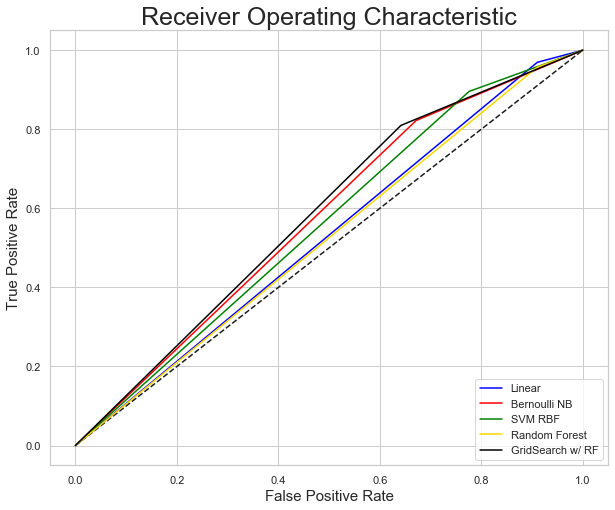

In [189]:

y_pred_prob1 = logreg_clf.predict_proba(X_test)[:,1]
fpr1 , tpr1, thresholds1 = roc_curve(y_test, y_pred_lr)

y_pred_prob2 = B_nb.predict_proba(X_test)[:,1]
fpr2 , tpr2, thresholds2 = roc_curve(y_test, y_pred_Bnb)

y_pred_prob3 = clf_rbf.predict_proba(X_test)[:,1]
fpr3 , tpr3, thresholds3 = roc_curve(y_test, y_pred_rbf)

y_pred_prob4 = rfc_classifier.predict_proba(X_test)[:,1]
fpr4 , tpr4, thresholds3 = roc_curve(y_test, y_pred_RF)

y_pred_prob5 = grid_tree.predict_proba(X_test)[:,1]
fpr5 , tpr5, thresholds4 = roc_curve(y_test, grid_tree_pred)


fig, ax = plt.subplots(figsize=(10,8))
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "Linear", color="blue")
plt.plot(fpr2, tpr2, label= "Bernoulli NB", color = "red")
plt.plot(fpr3, tpr3, label= "SVM RBF", color = "green")
plt.plot(fpr4, tpr4, label= "Random Forest", color = "gold")
plt.plot(fpr5, tpr5, label= "GridSearch w/ RF", color = "black")
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.title('Receiver Operating Characteristic', fontsize=25)
plt.legend(loc="lower right")
plt.savefig("images/roc");

# Feature Importances

### Feature Importance from Logistic Regression

In [118]:
print(logreg_clf.coef_)

[[-1.85042278e-02 -9.15141974e-05 -5.14109165e-01 ... -2.25222131e-01
   8.16512750e-02  2.94156384e-01]]


In [119]:
def get_coef_name(fit_model, df):
    temp = (list(zip(fit_model.coef_[0], df.columns)))
    return sorted(temp,key = lambda x: x[0], reverse=True)

In [120]:
log_reg_coef=pd.DataFrame(get_coef_name(logreg_clf, X_train), columns = ["coefficient", "feature"])

In [121]:
# top 5 (positive) and Bottom 5 (negative) gives you the 5 most positve and 5 most negative values. 
top5_coef = pd.concat([log_reg_coef.head(),log_reg_coef.tail()])

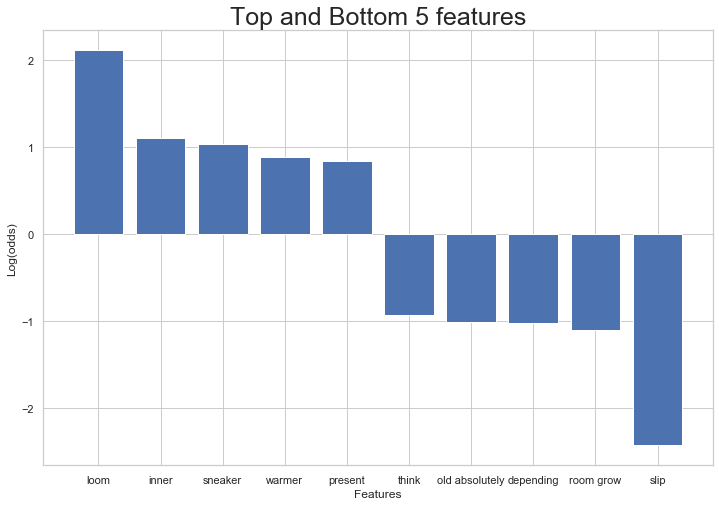

In [190]:
fig, ax = plt.subplots(figsize = (12,8))
plt.bar(x = top5_coef.feature, height=top5_coef.coefficient)
plt.title("Top and Bottom 5 features", fontsize=25)
plt.xlabel("Features")
plt.ylabel("Log(odds)")
plt.savefig("images/log_coef_feats");

### Feature Importance from Random Forest

In [123]:
def get_feats_name(fit_model, df):
    temp = (list(zip(fit_model.best_estimator_.feature_importances_, df.columns)))
    return sorted(temp,key = lambda x: x[0], reverse=True)

In [124]:
#get_feats_name(grid_tree, X_train)

In [125]:
grid_tree_feats=pd.DataFrame(get_feats_name(grid_tree, X_train), columns = ["importance", "feature"])

In [126]:
grid_tree_feats[grid_tree_feats.importance>0.01]

,importance,feature
0,0.032215,loom
1,0.029649,slip
2,0.017945,chance
3,0.017457,depending
4,0.017191,pocket
5,0.016191,sneaker
6,0.015940,room grow
7,0.014145,point
8,0.013833,champion
9,0.013244,price point


In [127]:
top5_feats = pd.concat([grid_tree_feats.head(12)])

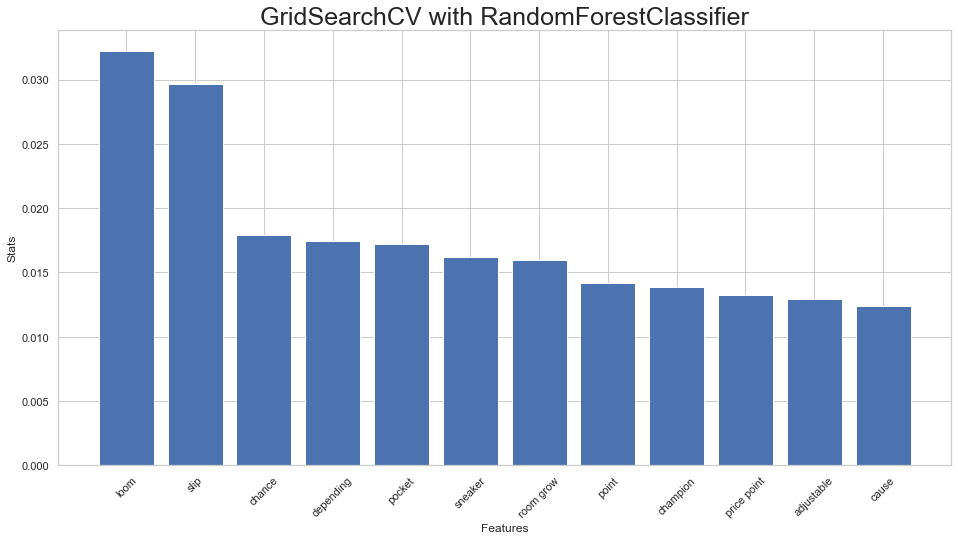

In [128]:
fig, ax = plt.subplots(figsize = (16,8))
plt.bar(x = top5_feats.feature, height=top5_feats.importance)
plt.title("GridSearchCV with RandomForestClassifier", fontsize=25)
plt.xlabel("Features")
plt.ylabel("Stats")
plt.xticks(rotation=45)
plt.savefig();

In [129]:
d={'Stats':X.columns,'FI':grid_tree.best_estimator_.feature_importances_}

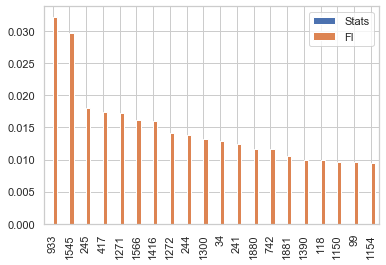

In [130]:
data = pd.DataFrame.from_dict(d, orient="index")
data = data.transpose()
data = data.sort_values(by='FI', ascending=False)
data[:20].plot(kind="bar")

In [131]:
data.drop(columns="Stats", inplace=True)
data.reset_index(inplace=True)
data.rename(columns={"index":"Stats"}, inplace=True)
feat_imp=data[:10].sort_values(by='FI', ascending=False)

In [132]:
feat_imp

,Stats,FI
0,933,0.0322153
1,1545,0.0296495
2,245,0.0179451
3,417,0.0174574
4,1271,0.017191
5,1566,0.0161911
6,1416,0.0159399
7,1272,0.0141448
8,244,0.0138332
9,1300,0.0132443


In [133]:
dataset = [d.split() for d in df.delisted]
vocab = gensim.corpora.Dictionary(dataset)


In [134]:
vocab[3824]

'complimentary,'

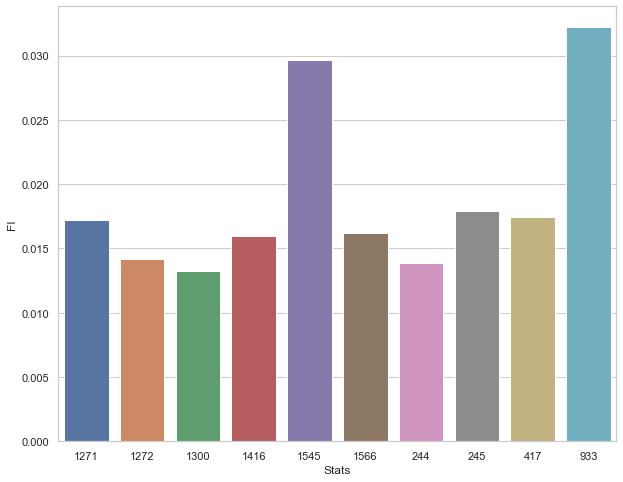

In [135]:
x=feat_imp.Stats.astype("str")
y=feat_imp.FI

fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(x=x, y=y, data = feat_imp)

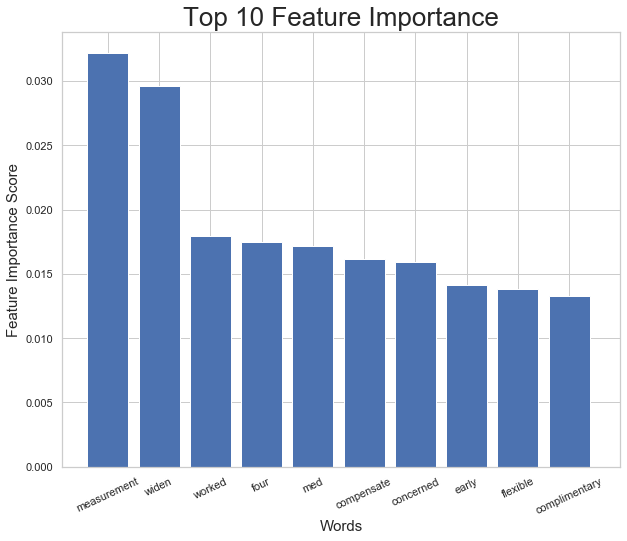

In [136]:
fig, ax = plt.subplots(figsize=(10,8))
plt.bar(x=x, height=y, data = feat_imp)

x = ['measurement', 'widen', 'worked', 'four', 'med', 'compensate', 'concerned', 'early', 'flexible', 'complimentary']
l = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


ax.set_xticks(l)
ax.set_xticklabels(x)
plt.xticks(rotation=25)
plt.title("Top 10 Feature Importance", fontsize=26)
plt.ylabel("Feature Importance Score", fontsize=15)
plt.xlabel("Words", fontsize=15);




# Post Modeling EDA with Feature Importances

In [137]:
df[df["clean_review_text"].str.contains("presentable")].target.value_counts()

1    6
0    2
Name: target, dtype: int64

In [138]:
df.iloc[57].review_text

'[\'Nice quality.  Seems a little small on the sizing.\', \'My husband doesn\\\'t usually wear polos but this is one he actually really liked. It fit him perfectly through the shoulders and the shirt was long enough to be tucked in (he\\\'s 6\\\'2", 205lbs and got an XL). He likes that the collar is a \\\'no flip\\\' style as well. He won\\\'t have to worry about messing with it constantly (one of the main reasons he doesn\\\'t usually wear polos) the fact that it also provides a bit of protection from the sun is an added bonus to it all! [This review was collected as part of a promotion.]\', \'Comfortable and Stylish polo for any day wear.  Literal wash, dry and wear.  Beautiful color with nice Izod logo.\', \'Classic polo look pairs well with jeans or slacks perfect for golf, shopping or hanging around the house.  Well made shirt with a quality expected from this manufacturer. [This review was collected as part of a promotion.]\', \'This was a gift for my boyfriend, who is very pleas